In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
shape_data = pd.read_csv('Dataset/csv/shape_preprocessed.csv')
shape_data.head()

,Path,Shape
0,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond
1,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond
2,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond
3,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond
4,Dataset/trafficsigns_dataset/diamond/rightofwa...,diamond


In [3]:
# Declare the number of classes in the dataset
OUTPUT_CLASSES_SHAPE = 5

Considerable class imbalance can be observed in the dataset. Hence we perform Stratified split to ensure that the distribution of classes is the same in both training and validation sets.

In [4]:
# split shape data into train, test, and validation sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(shape_data, test_size=0.2, random_state=42, stratify=shape_data['Shape'])
train_data, val_data = train_test_split(train_data, test_size=0.20, random_state=42, stratify=train_data['Shape'])

From the above figure it is clear that we have preserved the class distribution in training, validation and test sets.

In [5]:
# print the shape of the train, validation, and test sets
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2367, Val Data: 592, Test Data: 740


In [6]:
#copy train_data to new independent dataframe
train_data_new = train_data.copy()
train_data_new.head()
train_data_new['Shape'].value_counts()

Shape
round       1126
triangle     593
square       440
diamond      181
hex           27
Name: count, dtype: int64

In [7]:
# Convert the boolean encoding to integer
def bool_to_int(df_encoded) -> pd.DataFrame:
    """Convert boolean encoding to integer encoding"""
    for col in df_encoded.columns:
        if df_encoded[col].dtype == bool:
            df_encoded[col] = df_encoded[col].astype(int)
    return df_encoded

In [8]:
# One-hot encode 'Shape' column in the train data
train_data = pd.get_dummies(train_data, columns=['Shape'])

# One-hot encode 'Shape' column in the validation data
val_data = pd.get_dummies(val_data, columns=['Shape'])

# One-hot encode 'Shape' column in the test data
test_data = pd.get_dummies(test_data, columns=['Shape'])

In [9]:
# Convert boolean encoding to integer encoding
train_data = bool_to_int(train_data)
val_data = bool_to_int(val_data)
test_data = bool_to_int(test_data)

train_data.head()

,Path,Shape_diamond,Shape_hex,Shape_round,Shape_square,Shape_triangle
1422,Dataset/trafficsigns_dataset/triangle/warning/...,0,0,0,0,1
782,Dataset/trafficsigns_dataset/square/continue/0...,0,0,0,1,0
143,Dataset/trafficsigns_dataset/diamond/rightofwa...,1,0,0,0,0
443,Dataset/trafficsigns_dataset/square/parking/00...,0,0,0,1,0
1878,Dataset/trafficsigns_dataset/triangle/warning/...,0,0,0,0,1


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# normalize pixel values and build a data generator
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# normalize pixel values and build a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# choose 32 as the batch size
batch_size = 32

# train and validation generators
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Path",
        y_col=train_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Path",
        y_col=val_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,  # make sure you have a dataframe for test data
        directory='./',
        x_col="Path",
        y_col=test_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=1,
        color_mode='grayscale',
        class_mode='raw')

Found 2367 validated image filenames.
Found 592 validated image filenames.
Found 740 validated image filenames.


In [100]:
import os
import shutil
def copy_images(df, path):
    """Copies the images from the original dataset to the new directory"""
    for index, row in train_data.iterrows():
        # Get the image path and shape
        image_path = row['Path']
        shape = row['Shape']
        sub_dir = f"{shape}_aug"

        # Create a new directory for the shape if it doesn't exist
        new_dir = os.path.join(path, shape)
        os.makedirs(new_dir, exist_ok=True)

        # Copy the image to the new directory
        shutil.copy2(image_path, new_dir)

In [101]:
path = 'Dataset/trafficsigns_dataset_train'
copy_images(train_data, path)

In [12]:
####################FOLDER HAS TO EXIST BFRHAND####################
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Path to the dataset
data_dir = 'Dataset/trafficsigns_dataset_train'

# Path to save augmented images
augmented_dir = os.path.join('Dataset', 'trafficsigns_dataset_augmented')
os.makedirs(augmented_dir, exist_ok=True)


# List of minority classes and their sizes
minority_classes = {
    'triangle': 593,
    'square': 440,
    'diamond': 181,
    'hex': 27
}

# Size of the majority class
majority_class_size = 1126  # 'round'

# Create the data generator for the minority classes
minority_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

# Generate augmented data for each minority class
for class_name, class_size in minority_classes.items():
    class_dir = os.path.join(data_dir, class_name)
    num_augmented_needed = majority_class_size - class_size

    # Generate augmented images for the minority class
    augmented_generator = minority_datagen.flow_from_directory(
        class_dir,
        target_size=(28, 28),
        batch_size = 1,
        save_to_dir=os.path.join(augmented_dir, class_name),
        save_prefix=f'{class_name}_aug',
        save_format='png',
        class_mode='binary'
    )

    # Generate the required number of augmented images
    for i in range(num_augmented_needed):
        next(augmented_generator)

Found 593 images belonging to 1 classes.


Found 440 images belonging to 1 classes.
Found 181 images belonging to 1 classes.
Found 27 images belonging to 1 classes.


In [13]:
# Traverse the folder tree and get the image paths, type and shape
import os
path_to_dataset = 'Dataset/trafficsigns_dataset_augmented'
image_path = []
sign_shape = []
for shape_folder in os.listdir(path_to_dataset):
    shape_path = os.path.join(path_to_dataset, shape_folder)
    print(shape_path)
    if os.path.isdir(shape_path):
        # get the parent shape folders
        for image_file in os.listdir(shape_path):
            # save the image paths, type and shape
            image_path.append(os.path.join(shape_path, image_file))
            sign_shape.append(shape_folder)
                    

Dataset/trafficsigns_dataset_augmented/hex
Dataset/trafficsigns_dataset_augmented/triangle
Dataset/trafficsigns_dataset_augmented/diamond
Dataset/trafficsigns_dataset_augmented/square


In [14]:
# Create a DataFrame from the data
data = {'Path': image_path, 'Shape': sign_shape}
augmented_df = pd.DataFrame(data)
augmented_df.tail(5)

,Path,Shape
3258,Dataset/trafficsigns_dataset_augmented/square/...,square
3259,Dataset/trafficsigns_dataset_augmented/square/...,square
3260,Dataset/trafficsigns_dataset_augmented/square/...,square
3261,Dataset/trafficsigns_dataset_augmented/square/...,square
3262,Dataset/trafficsigns_dataset_augmented/square/...,square


In [15]:
augmented_df.shape

(3263, 2)

In [16]:
# Count the number of each unique shape in the DataFrame
shape_counts = augmented_df['Shape'].value_counts()
print("Shape Counts:")
print(shape_counts)

Shape Counts:
Shape
hex         1099
diamond      945
square       686
triangle     533
Name: count, dtype: int64


In [17]:
# concatenate the augmented data to train_data
train_data_aug = pd.concat([train_data_new, augmented_df], ignore_index=True)

In [19]:
train_data_aug['Shape'].value_counts()

Shape
triangle    1126
square      1126
diamond     1126
round       1126
hex         1126
Name: count, dtype: int64

In [20]:
augmented_train_data = pd.get_dummies(train_data_aug, columns=['Shape'])
augmented_train_data.head()

,Path,Shape_diamond,Shape_hex,Shape_round,Shape_square,Shape_triangle
0,Dataset/trafficsigns_dataset/triangle/warning/...,False,False,False,False,True
1,Dataset/trafficsigns_dataset/square/continue/0...,False,False,False,True,False
2,Dataset/trafficsigns_dataset/diamond/rightofwa...,True,False,False,False,False
3,Dataset/trafficsigns_dataset/square/parking/00...,False,False,False,True,False
4,Dataset/trafficsigns_dataset/triangle/warning/...,False,False,False,False,True


In [21]:
augmented_train_data = bool_to_int(augmented_train_data)
augmented_train_data.head()

,Path,Shape_diamond,Shape_hex,Shape_round,Shape_square,Shape_triangle
0,Dataset/trafficsigns_dataset/triangle/warning/...,0,0,0,0,1
1,Dataset/trafficsigns_dataset/square/continue/0...,0,0,0,1,0
2,Dataset/trafficsigns_dataset/diamond/rightofwa...,1,0,0,0,0
3,Dataset/trafficsigns_dataset/square/parking/00...,0,0,0,1,0
4,Dataset/trafficsigns_dataset/triangle/warning/...,0,0,0,0,1


In [22]:
# Count the number of each unique shape in the DataFrame which is onehot encoded
class_counts = augmented_train_data.sum()
class_counts

Path              Dataset/trafficsigns_dataset/triangle/warning/...
Shape_diamond                                                  1126
Shape_hex                                                      1126
Shape_round                                                    1126
Shape_square                                                   1126
Shape_triangle                                                 1126
dtype: object

### Metric Selection
Considering that this is a multi-class calssification problem and the existing class imbalance in the dataset, we choose, classwise Precision, Recall, F1 Score and Support as the evaluation metrics. We also plot a confusion matrix to understand the model performance better.

Setup Diagnostics

In [23]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [24]:
def calc_model_performance(model, train_generator, validation_generator):
    train_loss, train_auc = model.evaluate(train_generator, verbose=2)
    val_loss, val_auc = model.evaluate(validation_generator, verbose=2)
    test_loss, test_auc = model.evaluate(test_generator, verbose=2)
    print('\n################## Model Performance ######################\n')
    print(f'Train loss: {train_loss:.4f}, \nTrain AUC-PR: {train_auc:.4f}')
    print(f'Validation loss: {val_loss:.4f}, \nValidation AUC-PR: {val_auc:.4f}')
    print(f'Test loss: {test_loss:.4f}, \nTest AUC-PR: {test_auc:.4f}')
    

In [25]:
from sklearn.metrics import classification_report
import numpy as np

def predict_labels(model, test_generator, test_data):
    # Get the class labels
    class_labels = list(test_data.columns[1:])
    # Predict on the test generator
    predictions = model.predict(test_generator)
    # Decode the predictions
    decoded_predictions = np.argmax(predictions, axis=1)
    # Map the decoded predictions to class labels
    predicted_labels = [class_labels[prediction] for prediction in decoded_predictions]
    # Assuming you have the true labels (y_true) and predicted labels (predicted_labels)
    y_true = test_data.iloc[:, 1:].idxmax(axis=1).values  # Get true labels from test_data
    # Calculate classification report
    report = classification_report(y_true, predicted_labels, target_names=class_labels)
    # Print the report
    print("\n################# Classification Report #################\n")
    print(report)

### Handle Class Imbalance
Class weighting


In [59]:
from sklearn.utils.class_weight import compute_class_weight

def calc_class_weight(y_train, class_labels):
    """Compute class weights for unbalanced classes"""
    
    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(len(class_labels)),  
        y=y_train.values.argmax(axis=1) 
    )
    print("Class Labels: ", class_labels)
    print("Class weights: ", class_weights)
    d_class_weights = dict(enumerate(class_weights))
    return d_class_weights

### Baseline CNN
We choose LeNet-5 as the baseline architecture for this task, as this architecture was originally developed for recognising handwritten digits of 28x28 size. As our data is also 28x28, we belive this architecture should be a good fit as a baseline.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Activation, MaxPool2D

def build_model():

    model = Sequential([
        Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=120, activation='relu'),
        Dense(units=84, activation='relu'),
        Dense(units=OUTPUT_CLASSES_SHAPE)
    ])
    

    return model

We have decided to follow the common LeNet-5 architecture
* Convolutional Layer 1: 6 filters of size 5x5 - This configuration is good for small grayscale images
* Convolutional Layer 2: 16 filters of size 5x5 - This is a common configuration
* Max Pooling Layer 1: 2x2 - To reduce the spatial dimensions of the image by half
* Dense Layer 1: 120 - Learns higher-level representations from the flattened convolutional features
* Dense Layer 2: 84 - This is also a common configuration
Relu activation function is used for all layers except the output layer as it introduces non-linearity and helps to learn more complex representations. We use softmax activation function in the output layer as this is a multi-class classification problem(as it outputs class probabilities that sum to 1)


In [61]:
import tensorflow as tf

def compile_model(model):
    model.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.AUC(name="AUCPR", curve="PR", from_logits=True)])
    return model

In [62]:
# Train the model
def train_model(model, train_generator, validation_generator, epochs=50, class_weights=None):
    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=epochs,
                        class_weight=class_weights,
                        verbose=2)
    return history

In [63]:
def pipeline(train_generator, validation_generator, epochs=50, class_weights=None):
    model = build_model()
    model = compile_model(model)
    history = train_model(model, train_generator, validation_generator, epochs=epochs, class_weights=class_weights)
    return model, history

Epoch 1/50


/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 - 7s - 102ms/step - AUCPR: 0.5883 - loss: 1.0566 - val_AUCPR: 0.8115 - val_loss: 0.6683
Epoch 2/50
70/70 - 2s - 29ms/step - AUCPR: 0.8596 - loss: 0.4780 - val_AUCPR: 0.8982 - val_loss: 0.3089
Epoch 3/50
70/70 - 2s - 29ms/step - AUCPR: 0.9243 - loss: 0.2502 - val_AUCPR: 0.9312 - val_loss: 0.2258
Epoch 4/50
70/70 - 2s - 27ms/step - AUCPR: 0.9537 - loss: 0.1627 - val_AUCPR: 0.9545 - val_loss: 0.1673
Epoch 5/50
70/70 - 2s - 28ms/step - AUCPR: 0.9668 - loss: 0.1110 - val_AUCPR: 0.9673 - val_loss: 0.1210
Epoch 6/50
70/70 - 2s - 29ms/step - AUCPR: 0.9755 - loss: 0.0633 - val_AUCPR: 0.9743 - val_loss: 0.0895
Epoch 7/50
70/70 - 2s - 25ms/step - AUCPR: 0.9742 - loss: 0.0461 - val_AUCPR: 0.9746 - val_loss: 0.0965
Epoch 8/50
70/70 - 2s - 27ms/step - AUCPR: 0.9808 - loss: 0.0341 - val_AUCPR: 0.9767 - val_loss: 0.0941
Epoch 9/50
70/70 - 2s - 29ms/step - AUCPR: 0.9794 - loss: 0.0288 - val_AUCPR: 0.9770 - val_loss: 0.0762
Epoch 10/50
70/70 - 2s - 28ms/step - AUCPR: 0.9767 - loss: 0.0190 - val_AU

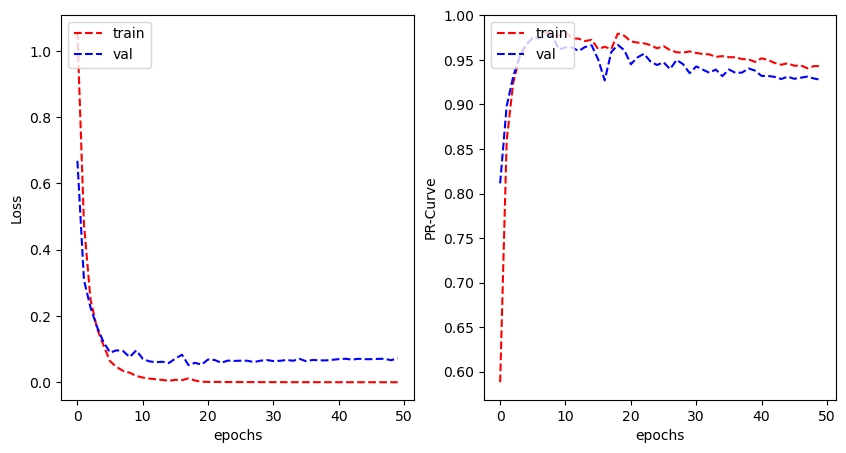

In [64]:
model, history = pipeline(train_generator, validation_generator, epochs=50)

# Plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['AUCPR'], history.history['val_AUCPR'],
                    metric_name='PR-Curve')

In [208]:
calc_model_performance(model, train_generator, validation_generator)

70/70 - 0s - 3ms/step - AUCPR: 0.8770 - loss: 6.9681e-05
24/24 - 0s - 4ms/step - AUCPR: 0.8595 - loss: 0.1409
740/740 - 0s - 669us/step - AUCPR: 0.8537 - loss: 0.0524

################## Model Performance ######################

Train loss: 0.0001, 
Train AUC-PR: 0.8770
Validation loss: 0.1409, 
Validation AUC-PR: 0.8595
Test loss: 0.0524, 
Test AUC-PR: 0.8537


In [209]:
predict_labels(model, test_generator, test_data)

740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step

################# Classification Report #################

                precision    recall  f1-score   support

 Shape_diamond       0.13      0.12      0.13        56
     Shape_hex       0.11      0.11      0.11         9
   Shape_round       0.46      0.46      0.46       352
  Shape_square       0.21      0.21      0.21       138
Shape_triangle       0.29      0.30      0.29       185

      accuracy                           0.34       740
     macro avg       0.24      0.24      0.24       740
  weighted avg       0.34      0.34      0.34       740



Re-Weight the classes

In [78]:
y_train = train_data.iloc[:, 1:]
class_labels = y_train.columns  # Get class labels from column names
class_weights = calc_class_weight(y_train=y_train, class_labels=class_labels)
print(class_weights)

Class Labels:  Index(['Shape_diamond', 'Shape_hex', 'Shape_round', 'Shape_square',
       'Shape_triangle'],
      dtype='object')
Class weights:  [ 2.61546961 17.53333333  0.42042629  1.07590909  0.79831366]
{0: 2.6154696132596684, 1: 17.533333333333335, 2: 0.42042628774422736, 3: 1.075909090909091, 4: 0.7983136593591905}


In [211]:
model, history = pipeline(train_generator, validation_generator, epochs=50, class_weights=class_weights)

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


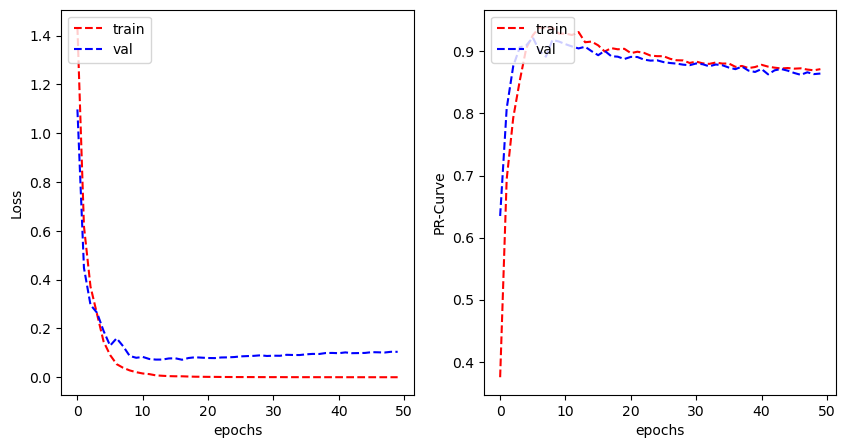

In [212]:
# Plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['AUCPR'], history.history['val_AUCPR'],
                    metric_name='PR-Curve')

In [213]:
calc_model_performance(model, train_generator, validation_generator)

70/70 - 0s - 3ms/step - AUCPR: 0.8717 - loss: 1.4065e-04
24/24 - 0s - 4ms/step - AUCPR: 0.8644 - loss: 0.1041
740/740 - 0s - 660us/step - AUCPR: 0.8668 - loss: 0.0541

################## Model Performance ######################

Train loss: 0.0001, 
Train AUC-PR: 0.8717
Validation loss: 0.1041, 
Validation AUC-PR: 0.8644
Test loss: 0.0541, 
Test AUC-PR: 0.8668


In [214]:
predict_labels(model, test_generator, test_data)

740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step

################# Classification Report #################

                precision    recall  f1-score   support

 Shape_diamond       0.15      0.14      0.15        56
     Shape_hex       0.00      0.00      0.00         9
   Shape_round       0.48      0.48      0.48       352
  Shape_square       0.18      0.18      0.18       138
Shape_triangle       0.24      0.24      0.24       185

      accuracy                           0.33       740
     macro avg       0.21      0.21      0.21       740
  weighted avg       0.33      0.33      0.33       740



Overfitting has reduced slightly

Learning rate scheduler

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# normalize pixel values and build a data generator
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# normalize pixel values and build a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# choose 32 as the batch size
batch_size = 32

# train and validation generators
train_generator = train_datagen.flow_from_dataframe(
        dataframe=augmented_train_data,
        directory='./',
        x_col="Path",
        y_col=train_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Path",
        y_col=val_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,  # make sure you have a dataframe for test data
        directory='./',
        x_col="Path",
        y_col=test_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=1,
        color_mode='grayscale',
        class_mode='raw')

Found 5630 validated image filenames.
Found 592 validated image filenames.
Found 740 validated image filenames.


In [29]:
import tensorflow as tf
# Rest of the code
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))
    

# def compile_model_with_scheduler(model):
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
#     model.compile(optimizer=optimizer,
#                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#                     metrics=[tf.keras.metrics.AUC(name="AUCPR", curve="PR", from_logits=True)])
#     return model
def compile_model_with_scheduler(model):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=['categorical_accuracy'])
    return model

In [30]:
def train_model_scheduler(model, train_generator, validation_generator, epochs=50, class_weights=None):
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=epochs,
                        class_weight=class_weights,
                        callbacks=[callback],
                        verbose=2)
    return history

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 - 7s - 39ms/step - categorical_accuracy: 0.1975 - loss: 1.6217 - val_categorical_accuracy: 0.0743 - val_loss: 1.6703 - learning_rate: 0.0010
Epoch 2/100
176/176 - 5s - 26ms/step - categorical_accuracy: 0.1934 - loss: 1.6117 - val_categorical_accuracy: 0.0760 - val_loss: 1.6439 - learning_rate: 0.0010
Epoch 3/100
176/176 - 5s - 28ms/step - categorical_accuracy: 0.1927 - loss: 1.6057 - val_categorical_accuracy: 0.1098 - val_loss: 1.6253 - learning_rate: 0.0010
Epoch 4/100
176/176 - 4s - 25ms/step - categorical_accuracy: 0.2266 - loss: 1.6010 - val_categorical_accuracy: 0.1875 - val_loss: 1.6119 - learning_rate: 0.0010
Epoch 5/100
176/176 - 5s - 26ms/step - categorical_accuracy: 0.2552 - loss: 1.5970 - val_categorical_accuracy: 0.2517 - val_loss: 1.6025 - learning_rate: 0.0010
Epoch 6/100
176/176 - 4s - 24ms/step - categorical_accuracy: 0.2876 - loss: 1.5931 - val_categorical_accuracy: 0.2889 - val_loss: 1.5947 - learning_rate: 0.0010
Epoch 7/100
176/176 - 4s - 25ms/step - categor

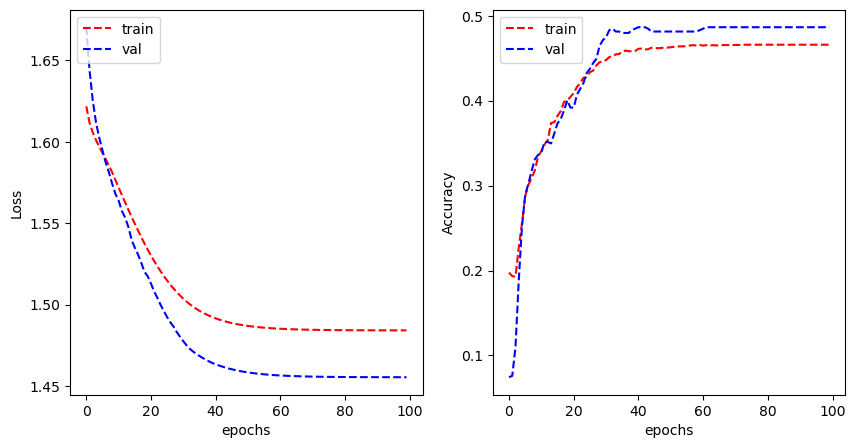

In [33]:
model = build_model()
model = compile_model_with_scheduler(model)
history = train_model_scheduler(model, train_generator, validation_generator, epochs=100, class_weights=None)


# Plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [34]:
calc_model_performance(model, train_generator, validation_generator)

176/176 - 4s - 23ms/step - categorical_accuracy: 0.4659 - loss: 1.4843
19/19 - 1s - 27ms/step - categorical_accuracy: 0.4865 - loss: 1.4555
740/740 - 3s - 4ms/step - categorical_accuracy: 0.4743 - loss: 1.4638

################## Model Performance ######################

Train loss: 1.4843, 
Train AUC-PR: 0.4659
Validation loss: 1.4555, 
Validation AUC-PR: 0.4865
Test loss: 1.4638, 
Test AUC-PR: 0.4743


In [35]:
predict_labels(model, test_generator, test_data)

740/740 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

################# Classification Report #################

                precision    recall  f1-score   support

 Shape_diamond       0.04      0.05      0.05        56
     Shape_hex       0.02      0.33      0.04         9
   Shape_round       0.56      0.25      0.34       352
  Shape_square       0.19      0.09      0.13       138
Shape_triangle       0.29      0.49      0.37       185

      accuracy                           0.26       740
     macro avg       0.22      0.24      0.18       740
  weighted avg       0.38      0.26      0.28       740



Early stopping

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
def train_model_early_stop(model, train_generator, validation_generator, epochs=50, class_weights=None):
    
    
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callback_learning_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)
    callback = [callback_early_stopping, callback_learning_rate]

    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=epochs,
                        class_weight=class_weights,
                        callbacks=[callback],
                        verbose=2)
    return history

Epoch 1/100


/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


176/176 - 7s - 42ms/step - categorical_accuracy: 0.2250 - loss: 1.6094 - val_categorical_accuracy: 0.4155 - val_loss: 1.5744 - learning_rate: 0.0010
Epoch 2/100
176/176 - 4s - 25ms/step - categorical_accuracy: 0.2803 - loss: 1.6010 - val_categorical_accuracy: 0.5084 - val_loss: 1.5712 - learning_rate: 0.0010
Epoch 3/100
176/176 - 4s - 25ms/step - categorical_accuracy: 0.3137 - loss: 1.5955 - val_categorical_accuracy: 0.5490 - val_loss: 1.5682 - learning_rate: 0.0010
Epoch 4/100
176/176 - 4s - 25ms/step - categorical_accuracy: 0.3334 - loss: 1.5903 - val_categorical_accuracy: 0.5507 - val_loss: 1.5639 - learning_rate: 0.0010
Epoch 5/100
176/176 - 4s - 24ms/step - categorical_accuracy: 0.3519 - loss: 1.5851 - val_categorical_accuracy: 0.5220 - val_loss: 1.5591 - learning_rate: 0.0010
Epoch 6/100
176/176 - 4s - 25ms/step - categorical_accuracy: 0.3611 - loss: 1.5797 - val_categorical_accuracy: 0.5270 - val_loss: 1.5518 - learning_rate: 0.0010
Epoch 7/100
176/176 - 4s - 24ms/step - categor

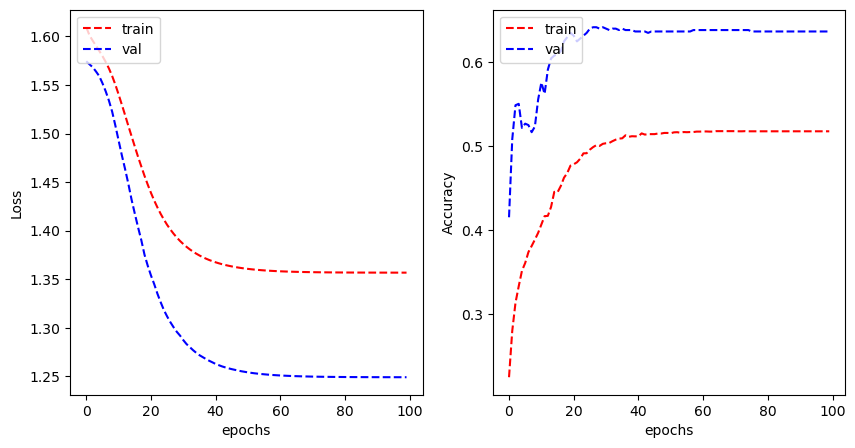

In [37]:
model = build_model()
model = compile_model_with_scheduler(model)
history = train_model_early_stop(model, train_generator, validation_generator, epochs=100, class_weights=None)
# Plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [81]:
calc_model_performance(model, train_generator, validation_generator)

74/74 - 2s - 21ms/step - AUCPR: 0.5065 - loss: 1.1607
19/19 - 0s - 25ms/step - AUCPR: 0.4943 - loss: 1.1642


/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


740/740 - 4s - 5ms/step - AUCPR: 0.4910 - loss: 1.1697

################## Model Performance ######################

Train loss: 1.1607, 
Train AUC-PR: 0.5065
Validation loss: 1.1642, 
Validation AUC-PR: 0.4943
Test loss: 1.1697, 
Test AUC-PR: 0.4910


In [82]:
predict_labels(model, test_generator, test_data)

740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

################# Classification Report #################

                precision    recall  f1-score   support

 Shape_diamond       0.00      0.00      0.00        56
     Shape_hex       0.00      0.00      0.00         9
   Shape_round       0.48      0.93      0.63       352
  Shape_square       0.00      0.00      0.00       138
Shape_triangle       0.32      0.09      0.14       185

      accuracy                           0.46       740
     macro avg       0.16      0.20      0.15       740
  weighted avg       0.31      0.46      0.34       740



/home/ashwin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashwin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashwin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [260]:
def pipeline(train_generator, validation_generator, epochs=50, class_weights=None):
    model = build_model()
    model = compile_model(model)
    history = train_model(model, train_generator, validation_generator, epochs=epochs, class_weights=class_weights)
    return model, history

In [261]:
model, history = pipeline(train_generator, validation_generator, epochs=100, class_weights=class_weights)

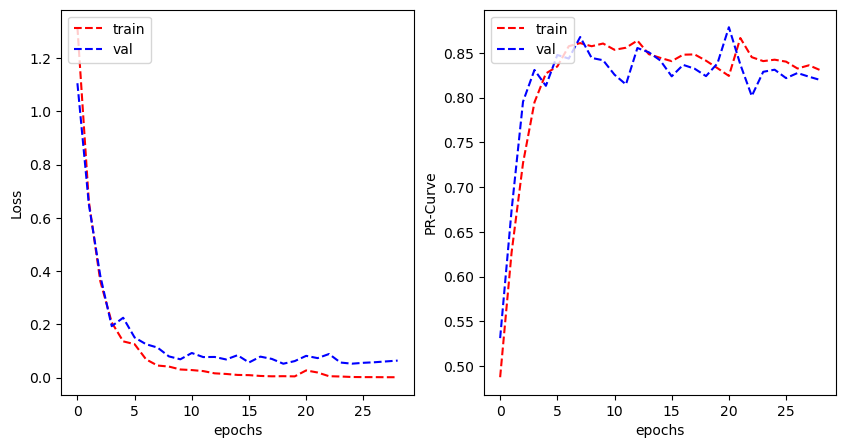

In [262]:
# Plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['AUCPR'], history.history['val_AUCPR'],
                    metric_name='PR-Curve')

In [263]:
calc_model_performance(model, train_generator, validation_generator)

70/70 - 0s - 3ms/step - AUCPR: 0.8232 - loss: 0.0010
24/24 - 0s - 4ms/step - AUCPR: 0.8196 - loss: 0.0635


/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


740/740 - 1s - 706us/step - AUCPR: 0.7998 - loss: 0.0497

################## Model Performance ######################

Train loss: 0.0010, 
Train AUC-PR: 0.8232
Validation loss: 0.0635, 
Validation AUC-PR: 0.8196
Test loss: 0.0497, 
Test AUC-PR: 0.7998


In [264]:
predict_labels(model, test_generator, test_data)

740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step

################# Classification Report #################

                precision    recall  f1-score   support

 Shape_diamond       0.13      0.12      0.13        56
     Shape_hex       0.11      0.11      0.11         9
   Shape_round       0.47      0.47      0.47       352
  Shape_square       0.17      0.17      0.17       138
Shape_triangle       0.25      0.25      0.25       185

      accuracy                           0.33       740
     macro avg       0.23      0.22      0.23       740
  weighted avg       0.33      0.33      0.33       740



Regularisation

In [237]:
import tensorflow as tf
def reg_model():
    reg_lambda = 0.001
    model = Sequential([
        Conv2D(filters=6, kernel_size=(5, 5), activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=16, kernel_size=(5, 5), activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=120, activation='relu'),
        Dense(units=84, activation='relu'),
        Dense(units=OUTPUT_CLASSES_SHAPE)
    ])
    return model


In [238]:
def pipelin_reg(train_generator_aug, validation_generator, epochs=50, class_weights=None):
    model = reg_model()
    model = compile_model(model)

    history = train_model(model, train_generator_aug, validation_generator, epochs=50, class_weights=None)
    return model, history

In [239]:
model, history = pipelin_reg(train_generator_aug, validation_generator, epochs=100, class_weights=None)

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


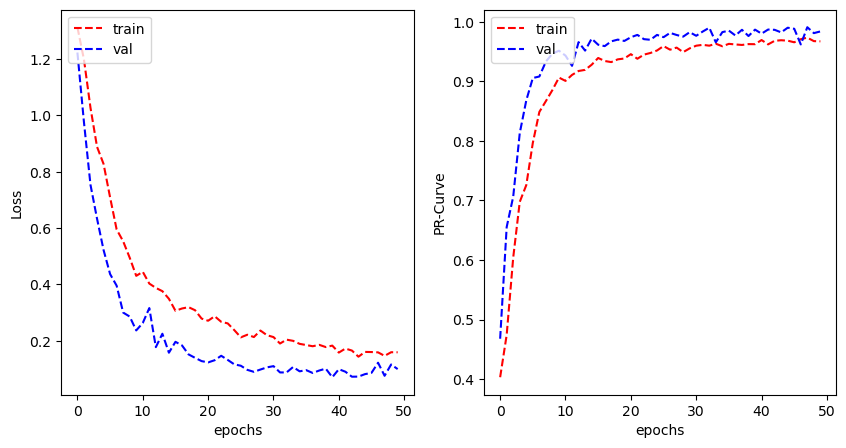

In [240]:
# Plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['AUCPR'], history.history['val_AUCPR'],
                    metric_name='PR-Curve')

In [241]:
calc_model_performance(model, train_generator, validation_generator)

70/70 - 0s - 3ms/step - AUCPR: 0.9920 - loss: 0.0630
24/24 - 0s - 4ms/step - AUCPR: 0.9840 - loss: 0.0994
740/740 - 1s - 678us/step - AUCPR: 0.9902 - loss: 0.0867

################## Model Performance ######################

Train loss: 0.0630, 
Train AUC-PR: 0.9920
Validation loss: 0.0994, 
Validation AUC-PR: 0.9840
Test loss: 0.0867, 
Test AUC-PR: 0.9902


In [242]:
predict_labels(model, test_generator, test_data)

740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step

################# Classification Report #################

                precision    recall  f1-score   support

 Shape_diamond       0.11      0.11      0.11        56
     Shape_hex       0.00      0.00      0.00         9
   Shape_round       0.47      0.47      0.47       352
  Shape_square       0.18      0.17      0.18       138
Shape_triangle       0.26      0.26      0.26       185

      accuracy                           0.33       740
     macro avg       0.20      0.20      0.20       740
  weighted avg       0.33      0.33      0.33       740



In [284]:
import kerastuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2

def kernel_size_to_string(kernel_size):
    return f"{kernel_size[0]}x{kernel_size[1]}"

def build_model(hp):
    model = Sequential()

    # Convolutional layer 1
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=4, max_value=16, step=4),
        kernel_size=tuple(map(int, hp.Choice('conv_1_kernel_size', [kernel_size_to_string((3, 3)), kernel_size_to_string((5, 5))]).split('x'))),
        activation='relu',
        input_shape=(28, 28, 1),
        kernel_regularizer=l1_l2(l1=hp.Choice('conv_1_l1_reg', [0.0, 1e-5, 1e-4, 1e-3]),
                                  l2=hp.Choice('conv_2_l2_reg', [0.0, 1e-5, 1e-4, 1e-3]))
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('conv_1_dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Convolutional layer 2
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=8, max_value=32, step=8),
        kernel_size=tuple(map(int, hp.Choice('conv_2_kernel_size', [kernel_size_to_string((3, 3)), kernel_size_to_string((5, 5))]).split('x'))),
        activation='relu',
        kernel_regularizer=l1_l2(l1=hp.Choice('conv_2_l1_reg', [0.0, 1e-5, 1e-4, 1e-3]),
                                  l2=hp.Choice('conv_2_l2_reg', [0.0, 1e-5, 1e-4, 1e-3]))
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('conv_2_dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Flatten layer
    model.add(Flatten())

    # Dense layer 1
    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=64, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=l1_l2(l1=hp.Choice('dense_1_l1_reg', [0.0, 1e-5, 1e-4, 1e-3]),
                                  l2=hp.Choice('dense_1_l2_reg', [0.0, 1e-5, 1e-4, 1e-3]))
    ))
    model.add(Dropout(hp.Float('dense_1_dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Dense layer 2
    model.add(Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
        activation='relu',
        kernel_regularizer=l1_l2(l1=hp.Choice('dense_2_l1_reg', [0.0, 1e-5, 1e-4, 1e-3]),
                                  l2=hp.Choice('dense_2_l2_reg', [0.0, 1e-5, 1e-4, 1e-3]))
    ))
    model.add(Dropout(hp.Float('dense_2_dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(OUTPUT_CLASSES_SHAPE, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='categorical_crossentropy',
        metrics=[tf.keras.metrics.AUC(name="AUCPR", curve="PR")]
    )

    return model

In [286]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_AUCPR',
    max_trials=5,
    executions_per_trial=5,
    directory='tuner_dir',
    project_name='lenet_tuning'
)

tuner.search(train_generator, epochs=75, validation_data=(validation_generator))

# Get the best hyperparameters and build the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

ValueError: Could not infer optimization direction ("min" or "max") for unknown metric "val_AUCPR". Please specify the objective  asa `keras_tuner.Objective`, for example `keras_tuner.Objective("val_AUCPR", direction="min")`.

In [273]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 12)     │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 16)       │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │        20,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,885 (358.93 KB)

 Trainable params: 91,885 (358.93 KB)

 Non-trainable params: 0 (0.00 B)

In [274]:
calc_model_performance(model, train_generator, validation_generator)

70/70 - 0s - 5ms/step - accuracy: 0.1870 - loss: 1.9424
24/24 - 0s - 4ms/step - accuracy: 0.1892 - loss: 1.9428
740/740 - 1s - 698us/step - accuracy: 0.1824 - loss: 1.9433

################## Model Performance ######################

Train loss: 1.9424, 
Train AUC-PR: 0.1870
Validation loss: 1.9428, 
Validation AUC-PR: 0.1892
Test loss: 1.9433, 
Test AUC-PR: 0.1824


In [275]:
predict_labels(model, test_generator, test_data)

740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step

################# Classification Report #################

                precision    recall  f1-score   support

 Shape_diamond       0.05      0.04      0.04        56
     Shape_hex       0.02      0.78      0.03         9
   Shape_round       0.00      0.00      0.00       352
  Shape_square       0.00      0.00      0.00       138
Shape_triangle       0.29      0.42      0.34       185

      accuracy                           0.12       740
     macro avg       0.07      0.25      0.08       740
  weighted avg       0.08      0.12      0.09       740



/home/ashwin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashwin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashwin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
